Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras_cv.losses import dice_loss
# from keras.losses import dice_loss
# from keras_retinanet.losses import focal_loss
# from keras_cv.metrics.segmentation import dice_loss






In [2]:
# import tensorflow as tf
# from keras import backend as K

# def dice_loss(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
    
#     # Print shapes for debugging
#     print("y_true_f shape:", y_true_f.shape)
#     print("y_pred_f shape:", y_pred_f.shape)
    
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
#     dice_coefficient = (2.0 * intersection + 1e-5) / (union + 1e-5)
#     dice_loss = 1.0 - dice_coefficient
    
#     return dice_loss



Constants

In [3]:
base_dir = 'D:\\projects\\fpn\\dataset\\data'
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'validation')
test_path = os.path.join(base_dir, 'test')
output_path = os.path.join(base_dir, 'Predictions')

Load CSV files containing pixel sizes and HC annotations

In [4]:
train_csv = pd.read_csv(os.path.join(base_dir, 'training_set_pixel_size_and_HC.csv'))
test_csv = pd.read_csv(os.path.join(base_dir, 'test_set_pixel_size.csv'))

Extract image IDs and corresponding annotations from CSV

In [5]:
train_image_ids = train_csv['filename']
train_annotations = train_csv['head circumference (mm)']

Split the data into train and validation sets

In [6]:
train_image_ids, val_image_ids, train_annotations, val_annotations = train_test_split(
    train_image_ids, train_annotations, test_size=0.1, random_state=42
)

load images & masks

In [7]:
def load_images(image_ids, images_dir, target_size=(256, 256)):
    images = []
    for image_id in image_ids:
        if int(image_id.split('_')[0]) < 78:
            continue  # Skip images below 078_HC
        image_path = os.path.join(images_dir, f"{image_id}")
        try:
            image = cv2.imread(image_path)
            if image is None:
                continue
            image = cv2.resize(image, target_size)
            images.append(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            continue
    return np.array(images)

def load_masks(image_ids, masks_dir, target_size=(256, 256)):
    masks = []
    for image_id in image_ids:
        if int(image_id.split('_')[0]) < 78:
            continue  # Skip masks below 078_HC
        mask_path = os.path.join(masks_dir, f"{image_id}")
        try:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            mask = cv2.resize(mask, target_size)
            masks.append(mask)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            continue
    return np.array(masks)

# Data augmentation functions

In [8]:
def augment_data(images, masks):
    augmented_images = []
    augmented_masks = []
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    for i in range(len(images)):
        img = images[i]
        mask = masks[i]

        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)

        aug_data = datagen.flow(img, mask, batch_size=1, seed=i, shuffle=False)

        augmented_image, augmented_mask = next(aug_data)

        augmented_image = np.squeeze(augmented_image, axis=0)
        augmented_mask = np.squeeze(augmented_mask, axis=0)

        augmented_images.append(augmented_image)  # Use append to create a list
        augmented_masks.append(augmented_mask)

    return np.array(augmented_images), np.array(augmented_masks)

preprocess images

In [10]:
def preprocess_image(img):
    img = img.astype('uint8')

    # Ensure 3 dimensions (add a channel if needed)
    if img.ndim == 2:
        img = img[..., np.newaxis]

    # Convert to grayscale if necessary
    if img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize the image to the desired dimensions (e.g., input_width and input_height)
    input_width = 256  # Replace with your desired width
    input_height = 256
    img = cv2.resize(img, (input_width, input_height))

    # Enhance image contrast or apply histogram equalization
    img = cv2.equalizeHist(img)

    # Normalize the image
    img = img / 255.0

    # Apply additional filters or image enhancements as needed
    # Example: Gaussian blur to reduce noise
    img = cv2.GaussianBlur(img, (3, 3), 0)

    img = img[:, :, np.newaxis]

    # Additional preprocessing steps specific to fetal head circumference measurement
    # ...

    return img

# Load and preprocess training data
train_images = load_images(train_image_ids, os.path.join(train_path, 'images'))
train_masks = load_masks(train_image_ids, os.path.join(train_path, 'masks'))

# Load and preprocess validation data
val_images = load_images(val_image_ids, os.path.join(train_path, 'images'))
val_masks = load_masks(val_image_ids, os.path.join(train_path, 'masks'))

# Shape verification after loading
print("Shapes after loading:")
print("Train Images:", train_images.shape)
print("Train Masks:", train_masks.shape)
print("Validation Images:", val_images.shape)
print("Validation Masks:", val_masks.shape)

# Data preprocessing
# Apply augmentation
train_images, train_masks = augment_data(train_images, train_masks)

# Shape verification after augmentation
print("\nShapes after augmentation:")
print("Train Images:", train_images.shape)
print("Train Masks:", train_masks.shape)

# Apply preprocessing
train_images = [preprocess_image(img) for img in train_images]
train_masks = [preprocess_image(mask) for mask in train_masks]

val_images = [preprocess_image(img) for img in val_images]
val_masks = [preprocess_image(mask) for mask in val_masks]

# Shape verification after preprocessing
print("\nShapes after preprocessing:")
print("Train Images:", np.array(train_images).shape)
print("Train Masks:", np.array(train_masks).shape)
print("Validation Images:", np.array(val_images).shape)
print("Validation Masks:", np.array(val_masks).shape)

Shapes after loading:
Train Images: (816, 256, 256, 3)
Train Masks: (816, 256, 256)
Validation Images: (88, 256, 256, 3)
Validation Masks: (88, 256, 256)

Shapes after augmentation:
Train Images: (816, 256, 256, 3)
Train Masks: (816, 256, 256)

Shapes after preprocessing:
Train Images: (816, 256, 256, 1)
Train Masks: (816, 256, 256, 1)
Validation Images: (88, 256, 256, 1)
Validation Masks: (88, 256, 256, 1)


post process mask

In [28]:
from scipy.ndimage import label

def postprocess_mask(mask):
    # Convert the probability mask to a binary mask
    threshold = 0.5
    binary_mask = tf.where(mask > threshold, 1.0, 0.0)

    # Remove small connected components (noise) from the binary mask
    min_component_size = 100
    binary_mask = remove_small_components(binary_mask, min_component_size)

    return binary_mask

def remove_small_components(mask, min_size):
    # Label connected components in the binary mask
    labeled_mask, num_components = label(mask)

    # Compute sizes of connected components
    component_sizes = np.bincount(labeled_mask.flatten())

    # Mask out components smaller than the specified size
    small_components = np.where(component_sizes < min_size)
    mask = np.isin(labeled_mask, small_components, invert=True).astype(float)

    return mask


# Define the Feature Pyramid Network (FPN) model architecture

In [12]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.layers import Input, Lambda
import tensorflow as tf

def custom_resnet_v2_preprocess_input(x):
    # Ensure the input has three channels (repeat single channel)
    x_rgb = tf.image.grayscale_to_rgb(x)
    return preprocess_input(x_rgb)
def create_fpn_model(input_shape=(None, None, 1), num_classes=1):
     # Create an Input layer with the specified input_shape
    input_tensor = Input(shape=input_shape)
     # Preprocess the input using the custom_resnet_v2_preprocess_input function
    preprocessed_input = Lambda(custom_resnet_v2_preprocess_input)(input_tensor)

   # Use ResNet50V2 model without top (include_top=False)
    backbone = ResNet50V2(weights='imagenet', include_top=False, input_tensor=preprocessed_input)


    # Create the FPN architecture
    # C3, C4, C5 are feature maps from different stages of the backbone
    C3, C4, C5 = [
        backbone.get_layer(layer_name).output for layer_name in ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    ]

    # Top-down pathway
    P5 = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(C5)
    P4 = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), activation='relu', padding='same')(P5)

    # Resize C4 to match the shape of P4
    C4_resized = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(C4)
    C4_resized = layers.UpSampling2D(size=(2, 2))(C4_resized)

    P4 = layers.Add()([C4_resized, P4])
    P3 = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), activation='relu', padding='same')(P4)

    # Resize C3 to match the shape of P3
    C3_resized = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(C3)
    C3_resized = layers.UpSampling2D(size=(2, 2))(C3_resized)

    P3 = layers.Add()([C3_resized, P3])

    # Prediction heads
    output_P3 = layers.Conv2D(num_classes, (3, 3), padding='same')(P3)
    output_P4 = layers.Conv2D(num_classes, (3, 3), padding='same')(P4)
    output_P5 = layers.Conv2D(num_classes, (3, 3), padding='same')(P5)

    # Upsample predictions to have the same resolution
    upsampled_P4 = layers.UpSampling2D(size=(2, 2))(output_P4)
    upsampled_P5 = layers.UpSampling2D(size=(4, 4))(output_P5)

    # Merge predictions
    final_output = layers.Add()([output_P3, upsampled_P4, upsampled_P5])
    
    # Create the model
    model = tf.keras.models.Model(
    inputs=backbone.input,
    outputs=final_output,  # Correctly specify the model's final output
    name='fpn_model'
)
    return model

    # Usage
input_height = 256
input_width = 256
input_channels = 1
fpn_model = create_fpn_model(input_shape=(input_height, input_width, input_channels), num_classes=1)

In [13]:
fpn_model.summary()

Model: "fpn_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['lambda[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                          

create FPN model 

In [14]:
fpn_model = create_fpn_model(input_shape=(input_height, input_width, input_channels), num_classes=1)


Compile the model

# Define callback for visualization during training

In [26]:
class VisualizationCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        num_visualizations = 5  # Adjust this based on how many visualizations you want to display
        indices = np.random.choice(len(val_images), num_visualizations, replace=False)

        for idx in indices:
            original_img = val_images[idx]
            true_mask = val_masks[idx]

            # Preprocess the image for prediction
            preprocessed_img = preprocess_image(original_img)
            preprocessed_img = np.expand_dims(preprocessed_img, axis=0)

            # Generate predictions
            predicted_mask = fpn_model.predict(preprocessed_img)[0]

            # Resize the predicted mask
            resized_predicted_mask = tf.image.resize(predicted_mask, (256, 256), method=tf.image.ResizeMethod.BILINEAR)

            # Post-processing steps
            resized_predicted_mask = postprocess_mask(resized_predicted_mask)

            # Plotting
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title('Original Image')
            plt.imshow(original_img)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title('True Mask')
            plt.imshow(true_mask.squeeze(), cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title('Resized Predicted Mask')
            plt.imshow(resized_predicted_mask.squeeze(), cmap='gray')  # Use the resized mask
            plt.axis('off')

            plt.show()


# Train the model

In [18]:
fpn_model.summary()


Model: "fpn_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['lambda_1[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                          

In [19]:
output_layer_name = fpn_model.layers[-1].name
print("Output layer name:", output_layer_name)


Output layer name: add_5


model compile 

In [20]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1.0 - (2.0 * intersection + 1.0) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.0)

# Assuming your model output is a single-channel probability map (sigmoid activation)
fpn_model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])




In [ ]:
model_output = fpn_model.predict(train_data)  # Assuming train_data is a batch of input images
print("Model Output Shape:", model_output.shape)


Shapes before fitting:
Train Input Shape: (816, 256, 256, 1)
Train Target Shape: (816, 32, 32, 1)
Sample Train Input Shape: (256, 256, 1)
Sample Train Target Shape: (32, 32, 1)
Sample Train Input Values: [[0.83287805 0.8332017  0.83352536 ... 0.         0.         0.        ]
 [0.83351475 0.832738   0.8319612  ... 0.         0.         0.        ]
 [0.8457385  0.84499407 0.84424967 ... 0.         0.         0.        ]
 ...
 [0.19215687 0.19215687 0.19215687 ... 0.2557323  0.27985772 0.28976142]
 [0.19215687 0.19215687 0.19215687 ... 0.25793296 0.28149047 0.29004538]
 [0.19215687 0.19215687 0.19215687 ... 0.26013362 0.28312322 0.29032934]]
Sample Train Target Values: tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 32), dtype=float32)
Epoch 1/10
1/1 [==============================] - 2s 2s/step- loss: 0.97


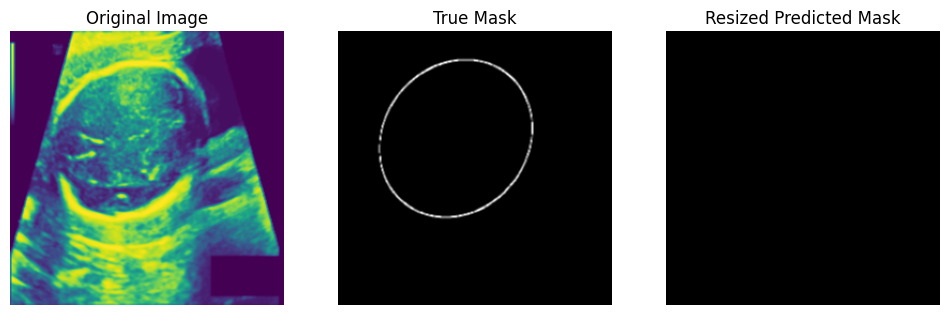

1/1 [==============================] - 0s 84ms/step


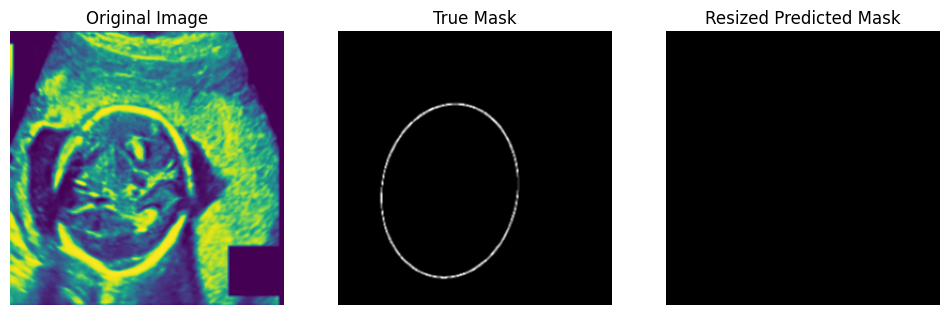

1/1 [==============================] - 0s 87ms/step


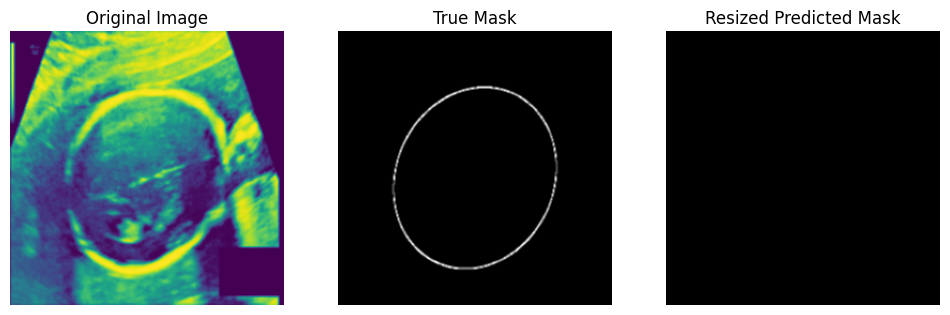

1/1 [==============================] - 0s 98ms/step


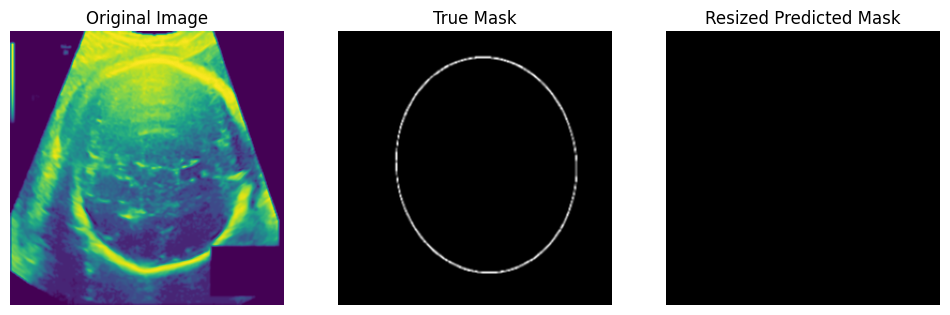

1/1 [==============================] - 0s 93ms/step


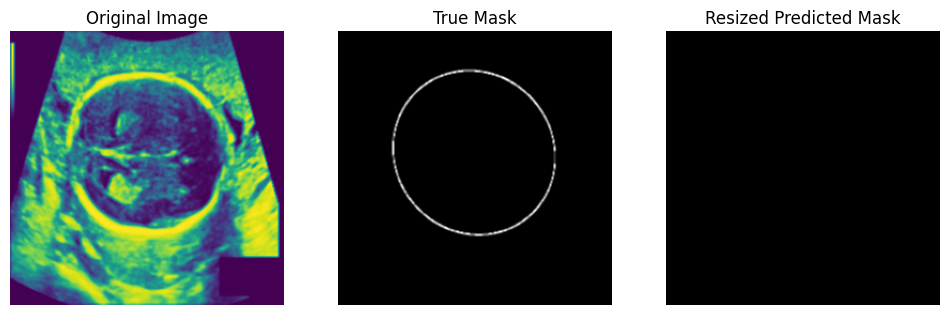

26/26 [==============================] - 130s 4s/step - loss: 0.9790 - val_loss: 0.9825
Epoch 2/10
1/1 [==============================] - 0s 88ms/steploss: 0.98


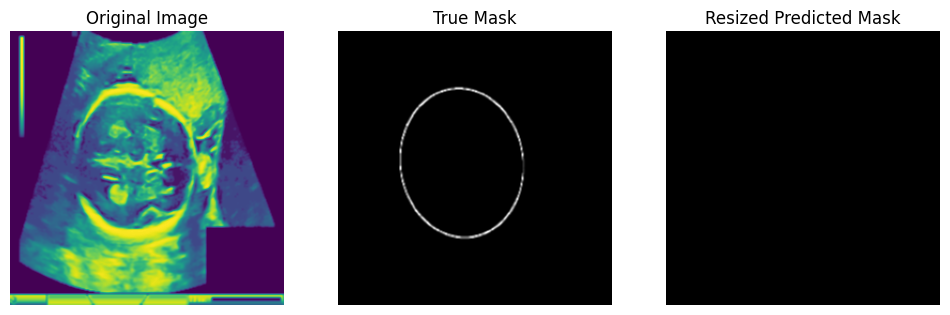

1/1 [==============================] - 0s 88ms/step


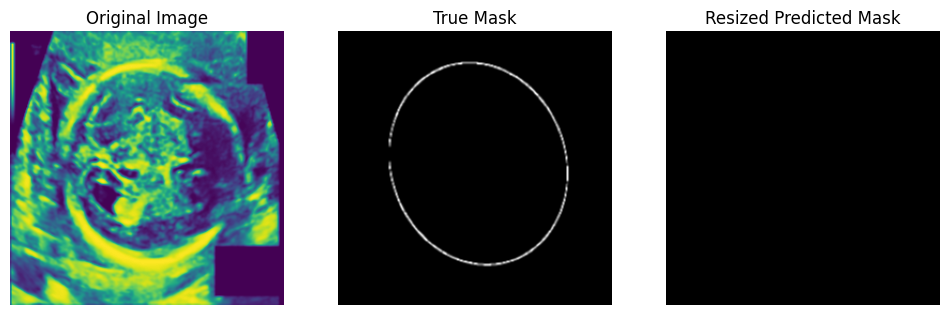

1/1 [==============================] - 0s 81ms/step


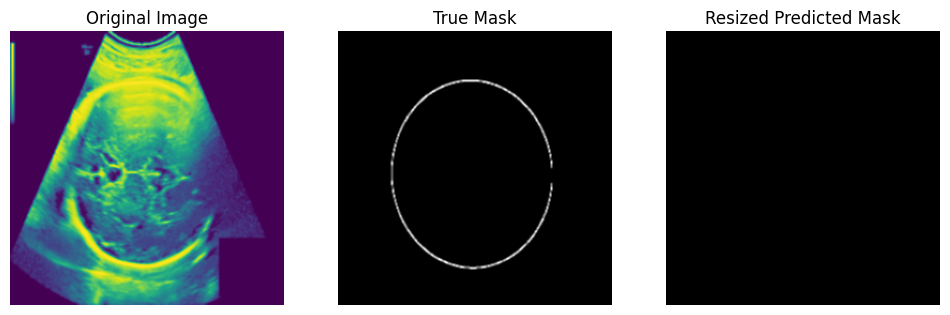

1/1 [==============================] - 0s 80ms/step


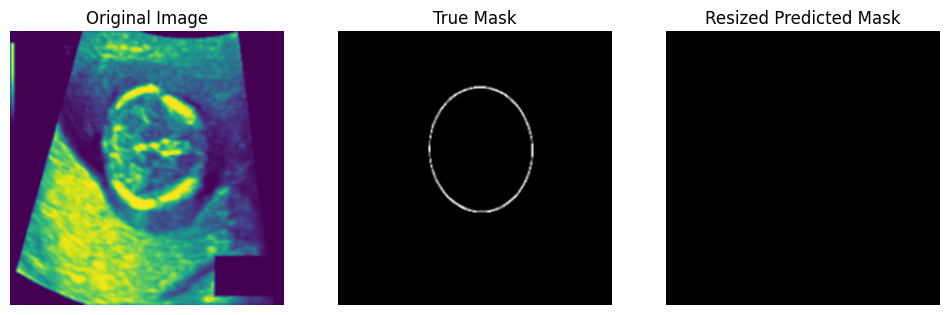

1/1 [==============================] - 0s 85ms/step


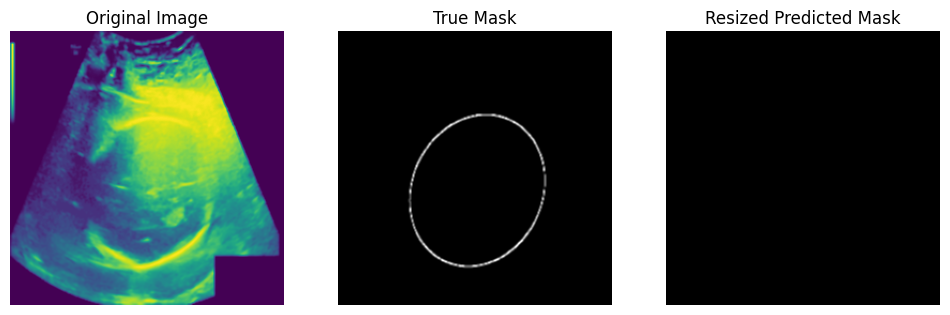

26/26 [==============================] - 111s 4s/step - loss: 0.9800 - val_loss: 0.9841
Epoch 3/10
1/1 [==============================] - 0s 86ms/steploss: 0.97


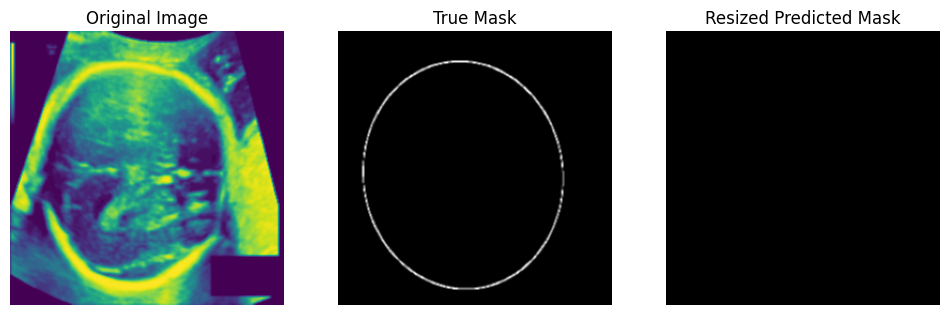

1/1 [==============================] - 0s 89ms/step


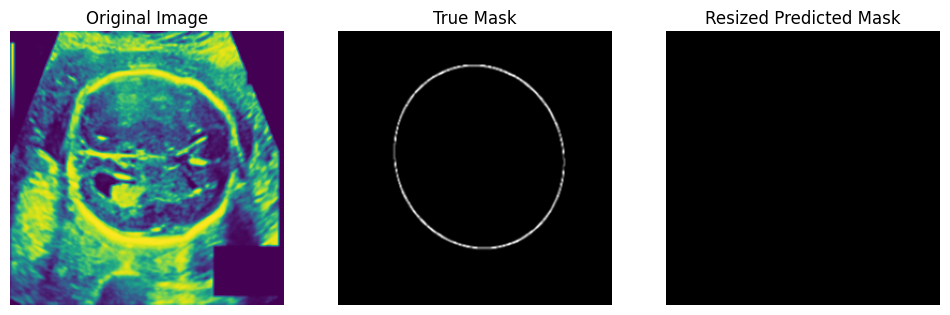

1/1 [==============================] - 0s 86ms/step


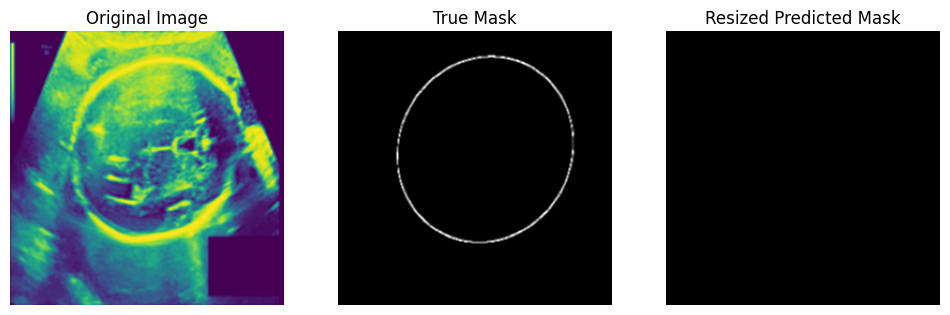

1/1 [==============================] - 0s 98ms/step


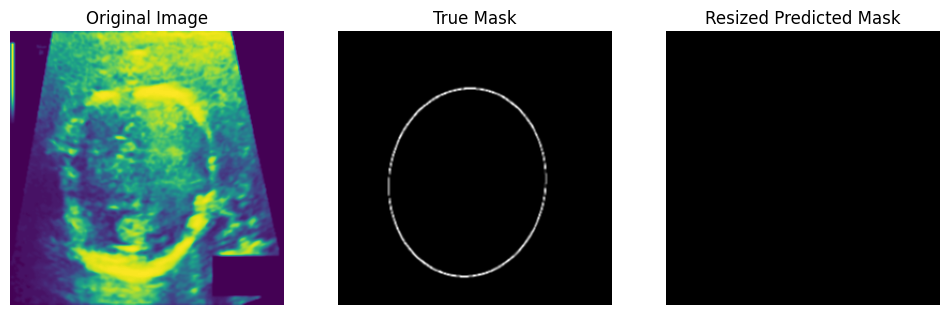

1/1 [==============================] - 0s 84ms/step


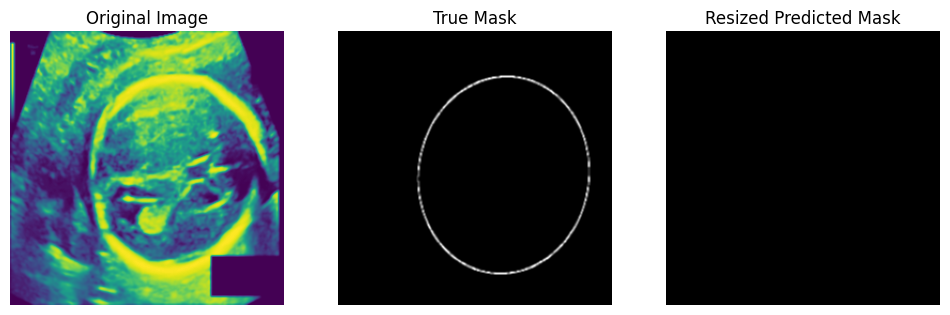

26/26 [==============================] - 113s 4s/step - loss: 0.9745 - val_loss: 0.9843
Epoch 4/10
1/1 [==============================] - 0s 92ms/steploss: 0.96


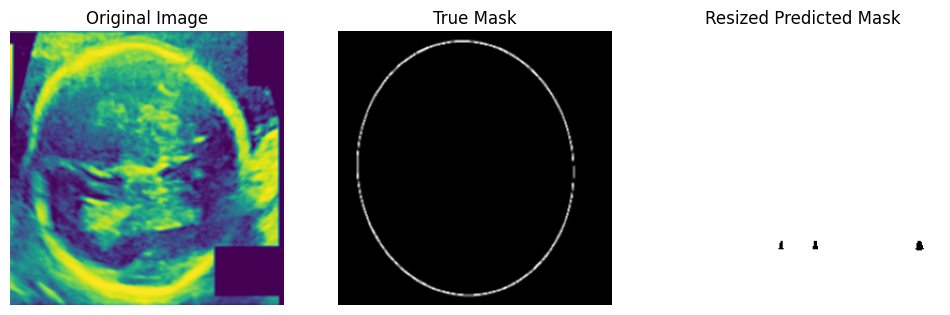

1/1 [==============================] - 0s 91ms/step


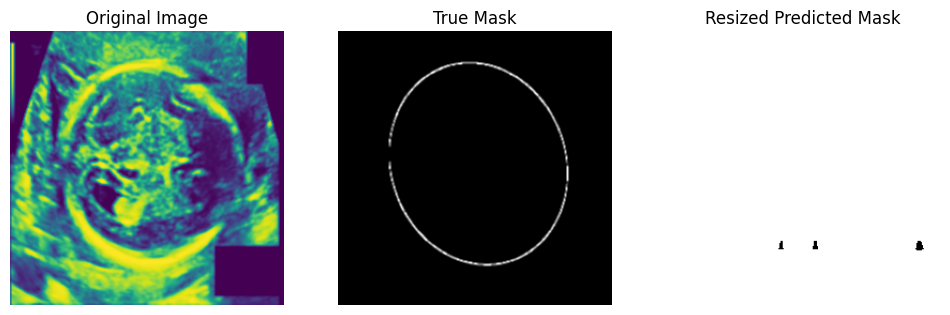

1/1 [==============================] - 0s 84ms/step


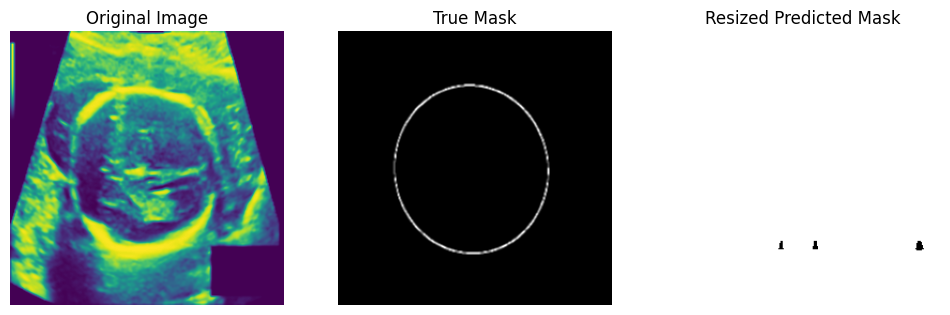

1/1 [==============================] - 0s 82ms/step


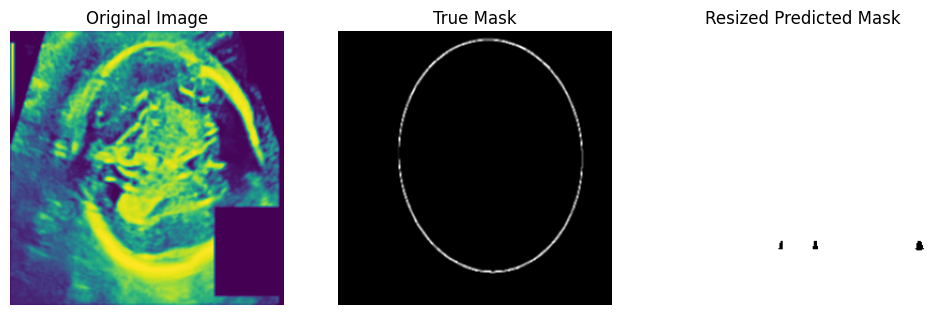

1/1 [==============================] - 0s 99ms/step


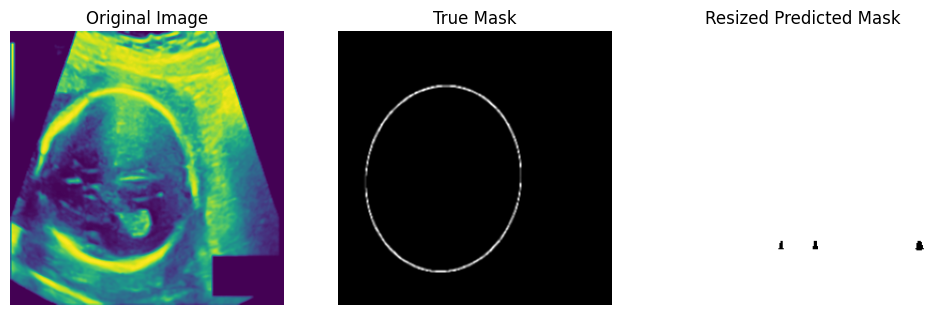

26/26 [==============================] - 111s 4s/step - loss: 0.9693 - val_loss: 0.9854
Epoch 5/10
1/1 [==============================] - 0s 87ms/steploss: 0.97


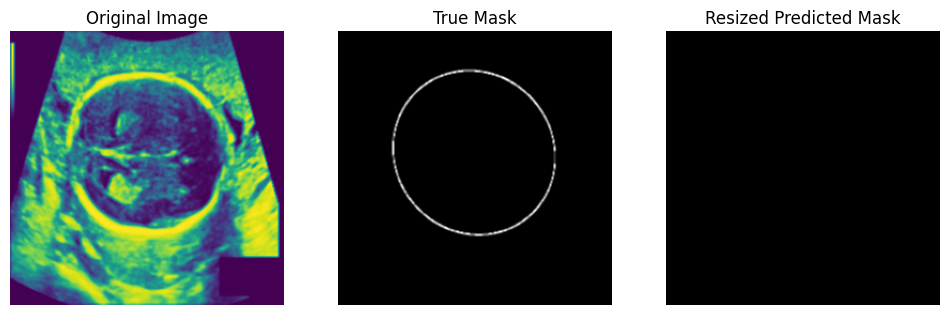

1/1 [==============================] - 0s 90ms/step


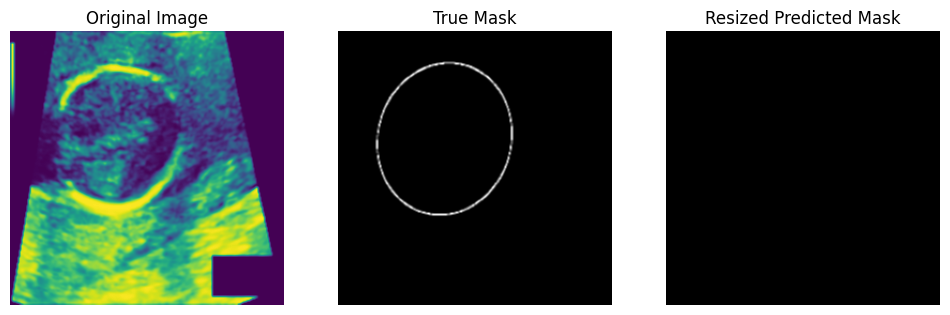

1/1 [==============================] - 0s 90ms/step


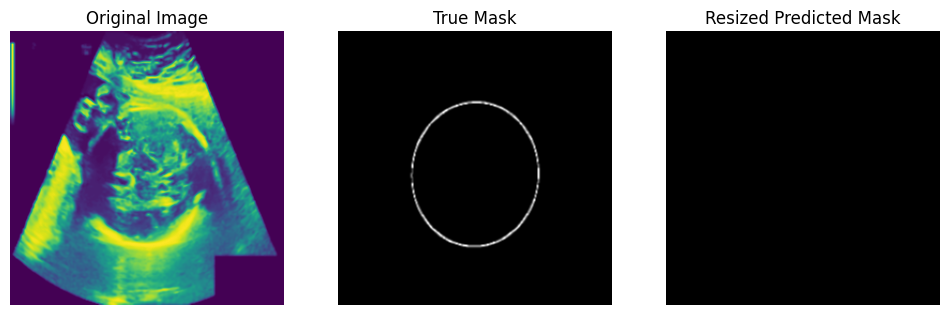

1/1 [==============================] - 0s 86ms/step


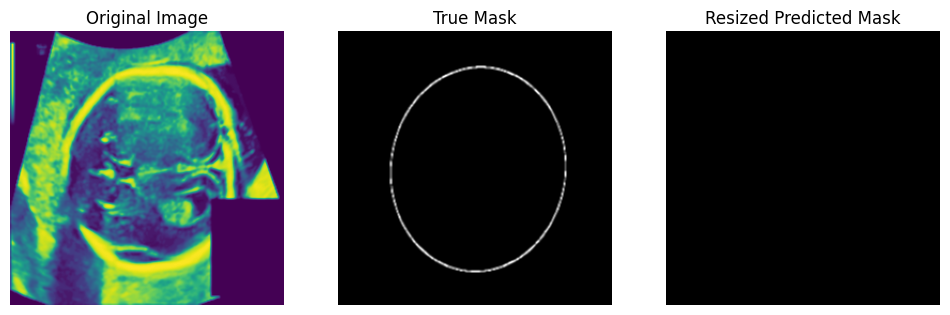

1/1 [==============================] - 0s 105ms/step


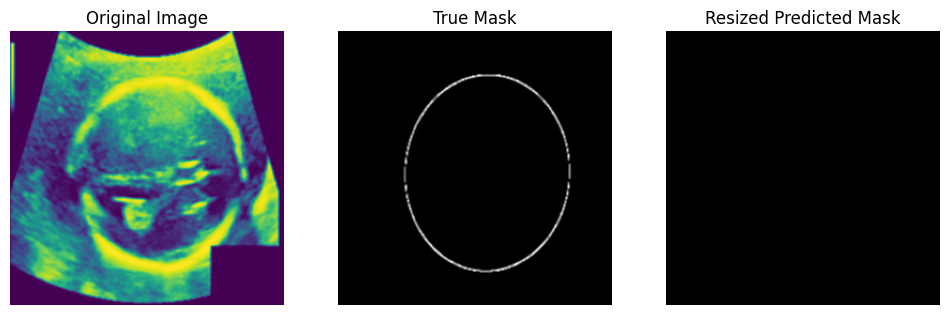

26/26 [==============================] - 111s 4s/step - loss: 0.9746 - val_loss: 0.9842
Epoch 6/10
1/1 [==============================] - 0s 91ms/steploss: 0.98


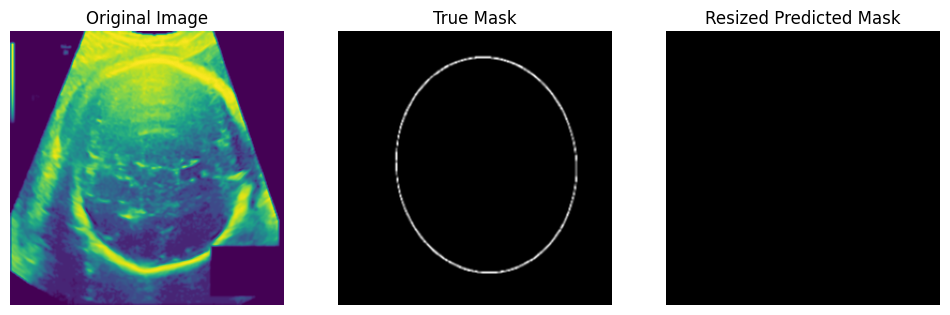

1/1 [==============================] - 0s 83ms/step


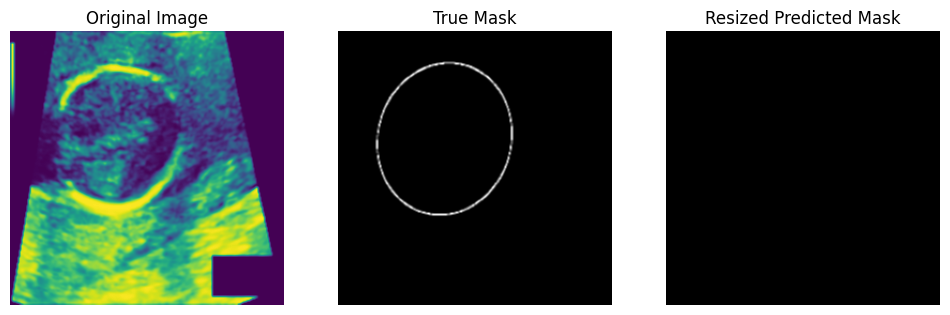

1/1 [==============================] - 0s 81ms/step


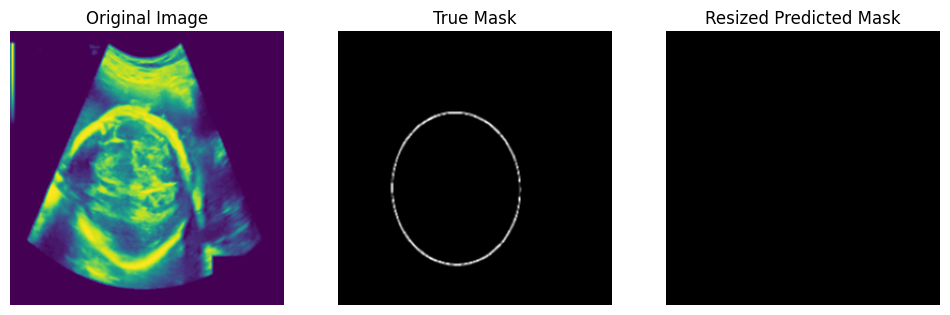

1/1 [==============================] - 0s 104ms/step


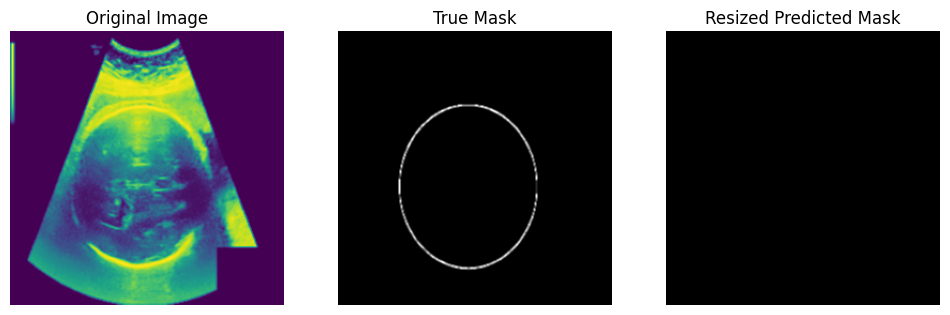

1/1 [==============================] - 0s 92ms/step


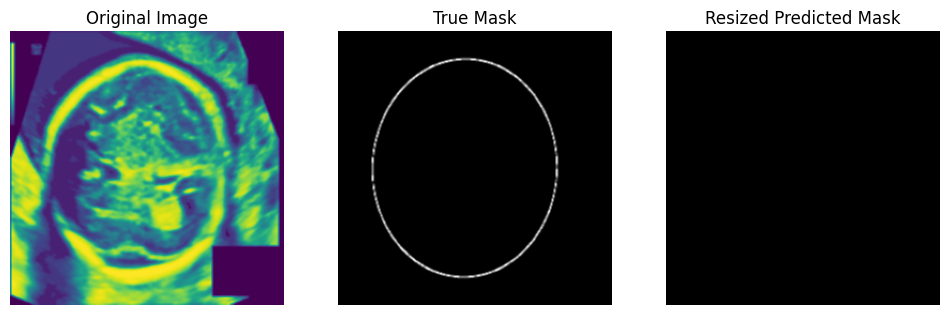

26/26 [==============================] - 111s 4s/step - loss: 0.9823 - val_loss: 0.9841
Epoch 7/10
1/1 [==============================] - 0s 86ms/steploss: 0.97


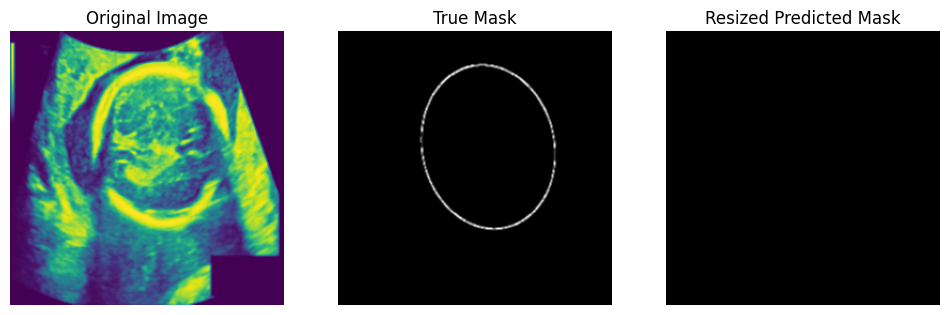

1/1 [==============================] - 0s 93ms/step


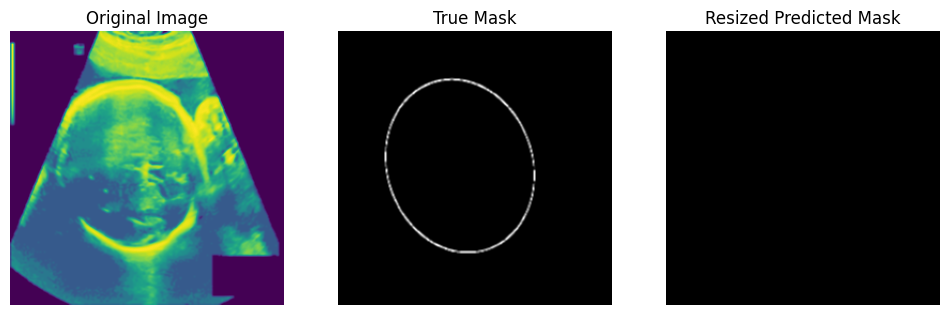

1/1 [==============================] - 0s 84ms/step


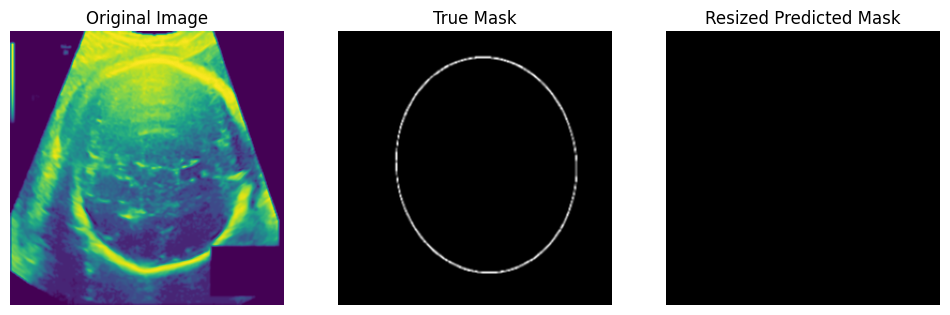

1/1 [==============================] - 0s 101ms/step


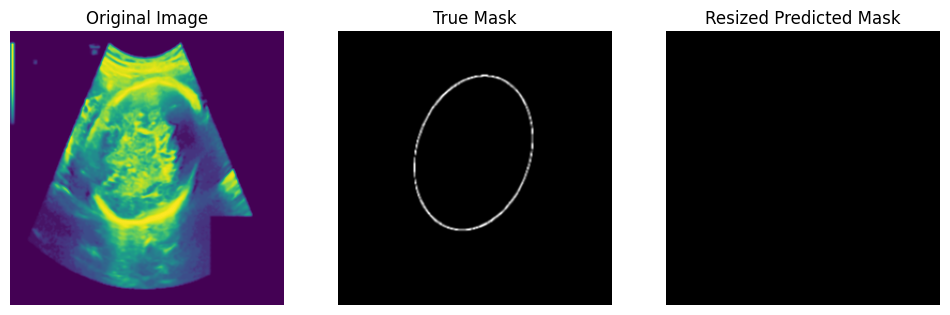

1/1 [==============================] - 0s 100ms/step


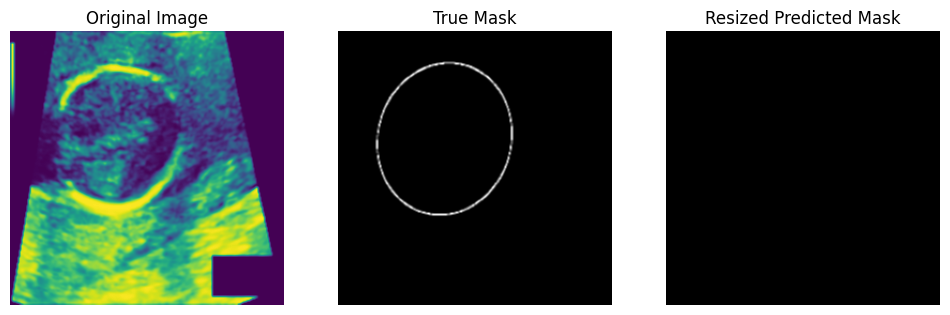

26/26 [==============================] - 110s 4s/step - loss: 0.9788 - val_loss: 0.9836
Epoch 8/10
1/1 [==============================] - 0s 88ms/steploss: 0.94


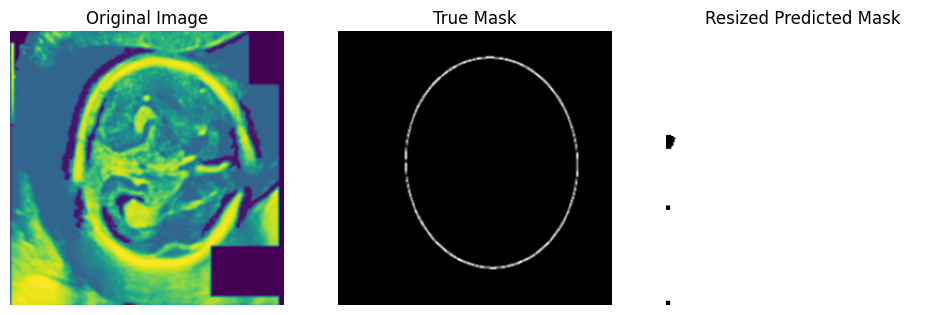

1/1 [==============================] - 0s 90ms/step


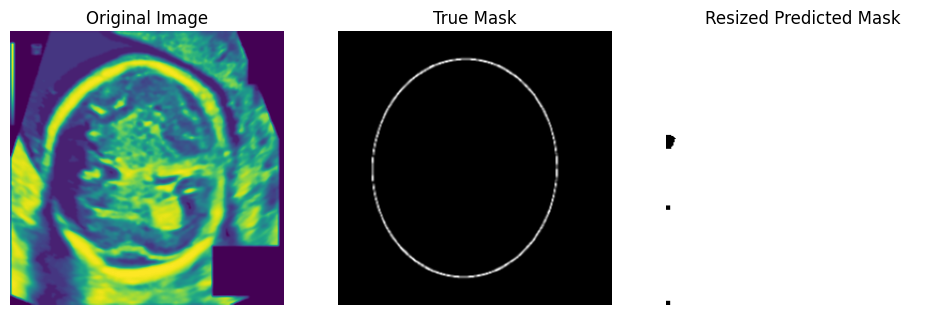

1/1 [==============================] - 0s 101ms/step


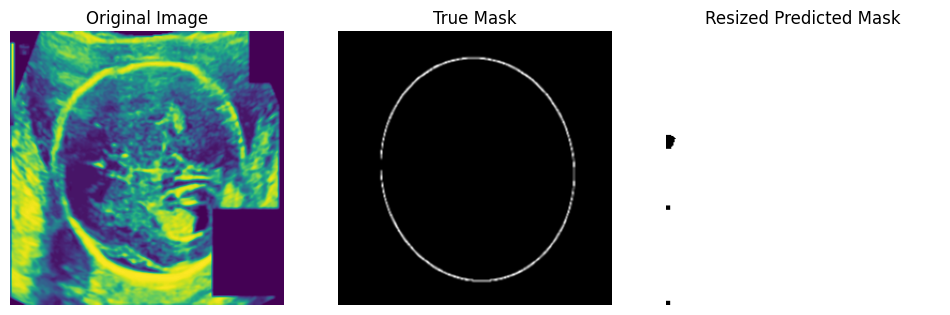

1/1 [==============================] - 0s 96ms/step


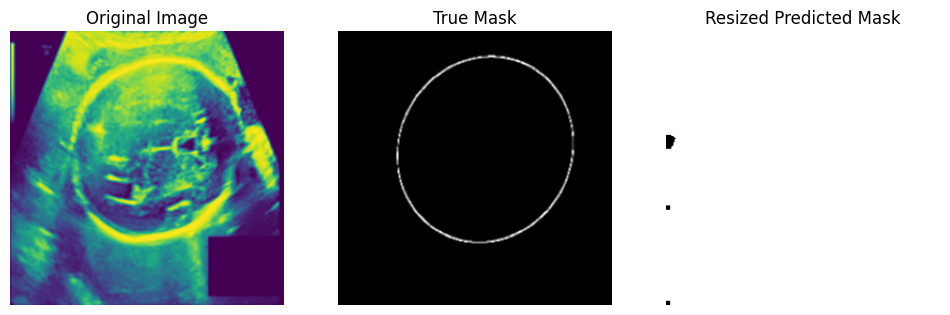

1/1 [==============================] - 0s 97ms/step


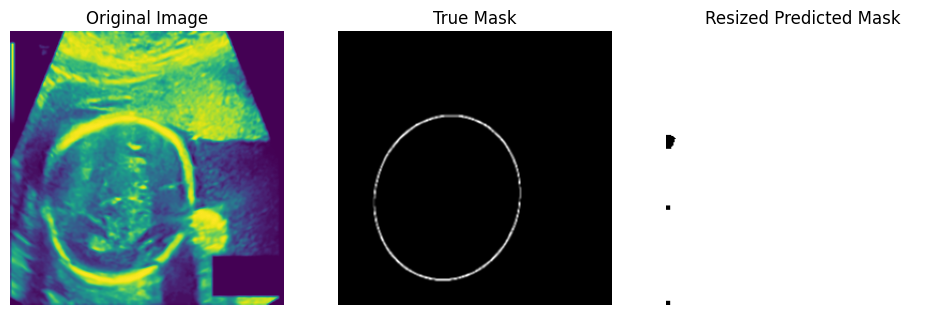

26/26 [==============================] - 110s 4s/step - loss: 0.9443 - val_loss: 0.9832
Epoch 9/10
1/1 [==============================] - 0s 94ms/steploss: 0.98


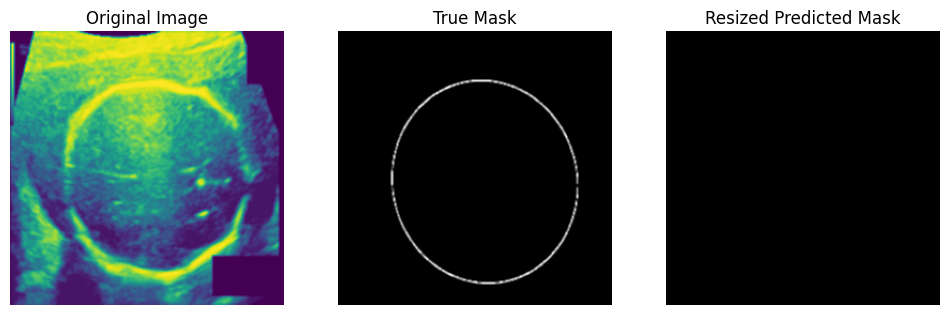

1/1 [==============================] - 0s 86ms/step


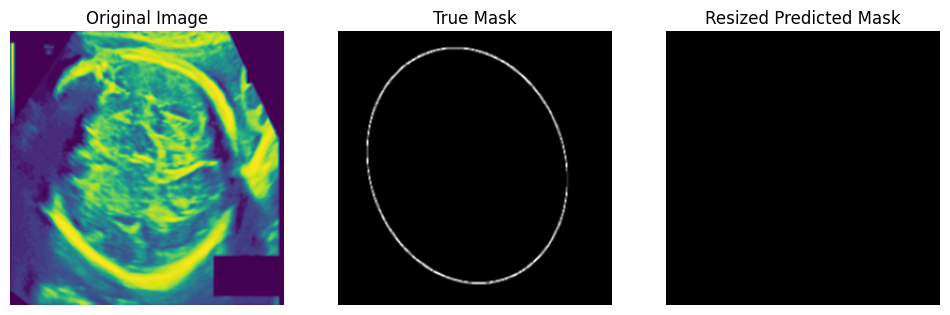

1/1 [==============================] - 0s 125ms/step


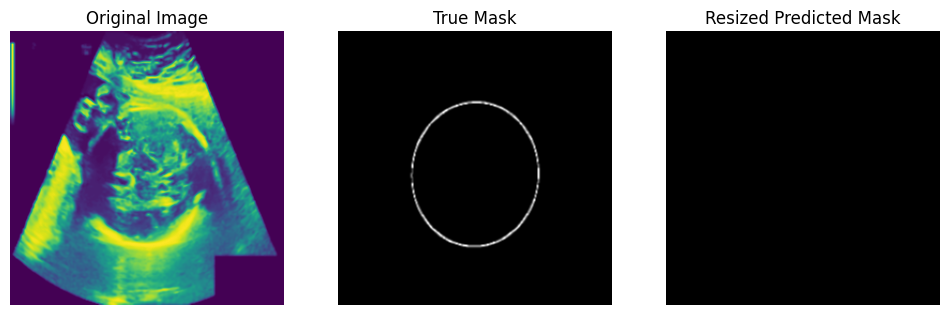

1/1 [==============================] - 0s 92ms/step


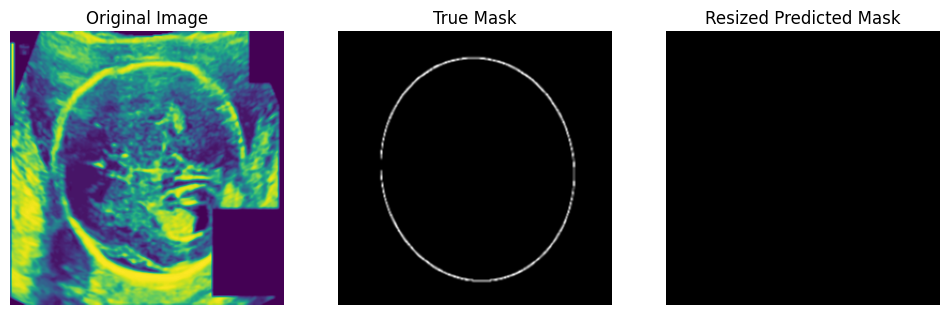

1/1 [==============================] - 0s 102ms/step


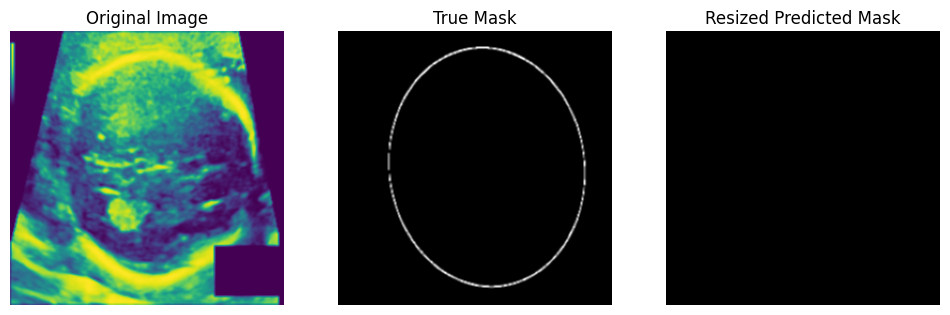

26/26 [==============================] - 109s 4s/step - loss: 0.9870 - val_loss: 0.9842
Epoch 10/10
1/1 [==============================] - 0s 90ms/steploss: 0.98


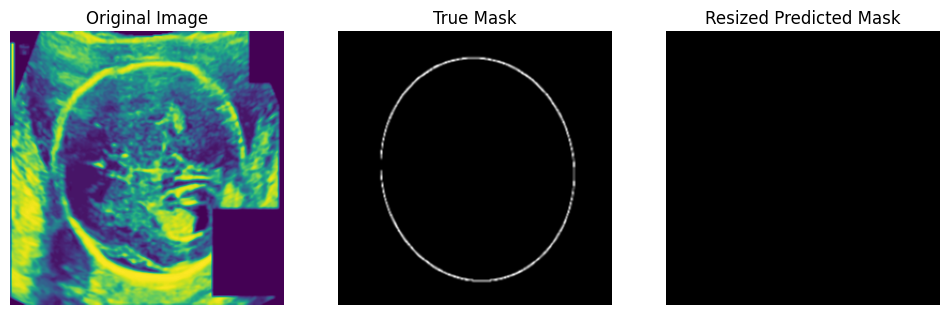

1/1 [==============================] - 0s 106ms/step


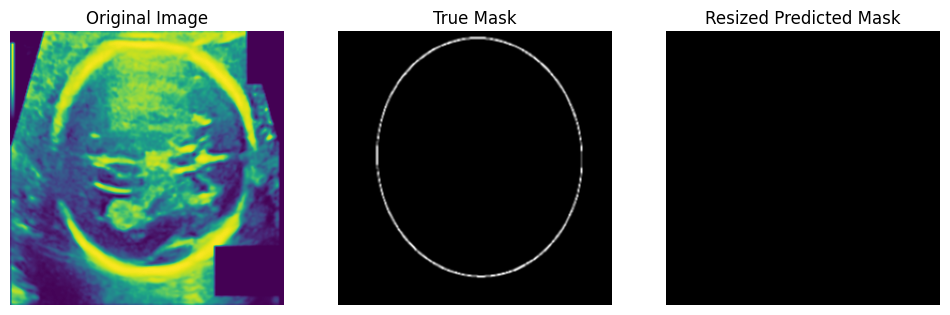

1/1 [==============================] - 0s 90ms/step


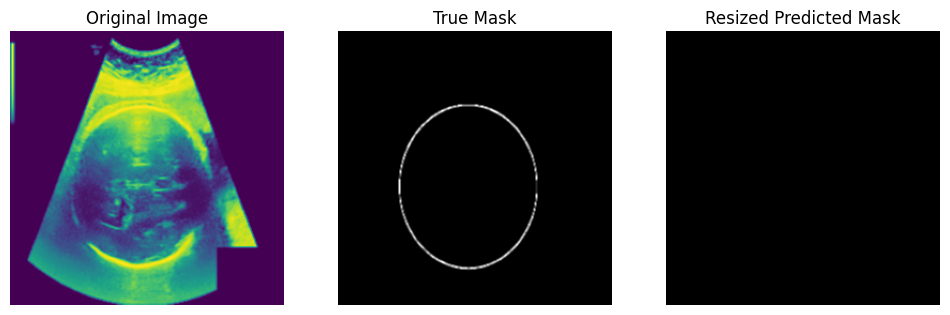

1/1 [==============================] - 0s 92ms/step


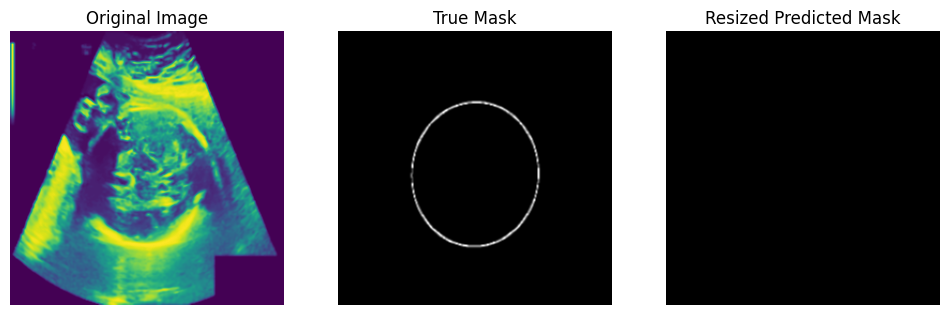

1/1 [==============================] - 0s 92ms/step


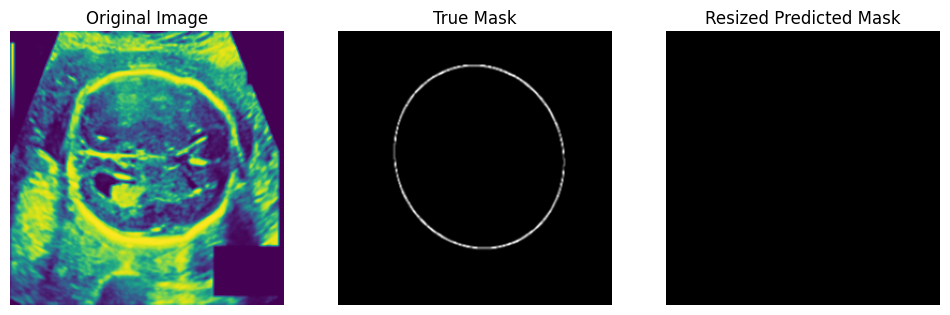

26/26 [==============================] - 114s 4s/step - loss: 0.9850 - val_loss: 0.9844


In [29]:
import tensorflow as tf

# 1. Augment data
augmented_images, augmented_masks = augment_data(train_images, train_masks)

# 2. Reshape augmented data
augmented_images = augmented_images.reshape((-1, 256, 256, 1))

# Convert val_images to NumPy array and then reshape
val_images_array = np.array(val_images)
val_images_array = val_images_array.reshape((val_images_array.shape[0], 256, 256, 1))

# Convert train_masks and val_masks to NumPy arrays and then reshape
train_masks_array = np.array(train_masks)
val_masks_array = np.array(val_masks)

train_target_data = train_masks_array.reshape((train_masks_array.shape[0], 256, 256, 1))
val_target_data = val_masks_array.reshape((val_masks_array.shape[0], 256, 256, 1))

# 3. Create data dictionaries
train_data = {'input_2': augmented_images}  # Assuming input layer name is 'input_7'
val_data = {'input_2': val_images_array}

# 4. Resize target data
resized_train_target_data = tf.image.resize(train_target_data, (32, 32), method=tf.image.ResizeMethod.BILINEAR)
val_target_data = tf.image.resize(val_target_data, (32, 32), method=tf.image.ResizeMethod.BILINEAR)

# Debugging prints
print("Shapes before fitting:")
print("Train Input Shape:", train_data['input_2'].shape)
print("Train Target Shape:", resized_train_target_data.shape)

# Print some sample values
print("Sample Train Input Shape:", train_data['input_2'][0].shape)
print("Sample Train Target Shape:", resized_train_target_data[0].shape)
print("Sample Train Input Values:", train_data['input_2'][0][:, :, 0])  # Assuming single-channel data
print("Sample Train Target Values:", resized_train_target_data[0][:, :, 0])  # Assuming single-channel data

# 5. Fitting the model
fpn_model.compile(optimizer='adam', loss=dice_loss)  # Add appropriate optimizer
fpn_model.fit(train_data, resized_train_target_data, epochs=10, validation_data=(val_data, val_target_data), callbacks=[VisualizationCallback()])

# Save the model

In [30]:
fpn_model.save(os.path.join(base_dir, 'fpn_model.h5'))

c:\Users\ASUS\anaconda3\envs\fpn3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Test Set Prediction

In [32]:
test_images = load_images(test_csv['Image_ID'], os.path.join(test_path, 'images'))
test_predictions = fpn_model.predict(test_images)

KeyError: 'Image_ID'


# Post-processing steps for masks

In [ ]:
def postprocess_mask(predicted_mask):
    # Example: Thresholding
    threshold = 0.5
    predicted_mask[predicted_mask >= threshold] = 1
    predicted_mask[predicted_mask < threshold] = 0

    # Example: Morphological operations (e.g., closing, opening)
    kernel = np.ones((5, 5), np.uint8)
    predicted_mask = cv2.morphologyEx(predicted_mask, cv2.MORPH_CLOSE, kernel)
    predicted_mask = cv2.morphologyEx(predicted_mask, cv2.MORPH_OPEN, kernel)

    # Example: Connected component analysis
    _, labels, stats, _ = cv2.connectedComponentsWithStats(predicted_mask.astype(np.uint8))
    largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    predicted_mask = (labels == largest_component).astype(np.float32)

    return predicted_mask


# Load and preprocess test data

In [ ]:
test_images = load_images(test_path)

# Predict on the test set

In [ ]:
test_predictions = fpn_model.predict(test_images)

# Post-processing and visual validation

In [ ]:
for i in range(len(test_images)):
    original_img = test_images[i]
    predicted_mask = test_predictions[i]

    # Post-processing steps and overlay masks on original images
    # Adjust these steps based on specific task requirements
    # Ensure predicted_mask and original_img have the same dimensions
    if predicted_mask.shape[:2] != original_img.shape[:2]:
        predicted_mask = cv2.resize(predicted_mask, (original_img.shape[1], original_img.shape[0]))

    # Perform additional post-processing steps here if needed
    predicted_mask = postprocess_mask(predicted_mask)

    # Example: Thresholding the predicted mask
    _, predicted_mask = cv2.threshold(predicted_mask, 0.5, 255, cv2.THRESH_BINARY)

    # Example: Convert single-channel mask to 3-channel for overlay
    predicted_mask = cv2.merge((predicted_mask, predicted_mask, predicted_mask))

    # Example: Apply a color (e.g., green) to the predicted mask for overlay
    predicted_mask[:, :, 1] = np.where(predicted_mask[:, :, 1] > 0, 255, 0)

    # Example: Overlay the predicted mask on the original image
    overlay = cv2.addWeighted(original_img, 0.7, predicted_mask, 0.3, 0)

    # Save the results to the output path
    cv2.imwrite(os.path.join(output_path, f'result_{i}.png'), overlay)


# Save predictions

In [ ]:
np.savetxt(os.path.join(output_path, 'predicted_values.csv'), test_predictions, delimiter=',')


# Evaluation

In [ ]:
if val_images is not None and val_masks is not None:
    evaluation_results = fpn_model.evaluate(val_images, val_masks)
    print("Validation Loss:", evaluation_results[0])
    print("Validation Metrics:", evaluation_results[1:])  # Additional metrics if available
